In [1]:
using DelimitedFiles
using PyPlot

### 181102: read multiple sequence alignment of HIV-1 gag

In [2]:
include("functions/parse_fasta_file.jl")
headers_fasta, sequences_fasta=read_fasta_file("LANL data/HIV-1_gag2.fasta")
headersall, sequencesall=remove_hxb2_fasta(headers_fasta,sequences_fasta)
num_samplesall=length(sequencesall)

The first header contains "HXB2". Returning only subsequent headers and sequences.


14564

### 181102: limit to p24 region and remove all insertions w.r.t. HXB2 sequence

In [3]:
# HXB2 sequence
hxb2seq=sequences_fasta[1]

# define start and end positions of p24 region in MSA
start_p24region=231
end_p24region=487
L=231

# HXB2 sequence with gaps in p24 region
hxb2seq_p24region=hxb2seq[start_p24region:end_p24region]

# find gaps in HXB2 sequence
indicesgaps_p24region=findall(isequal('-'),hxb2seq_p24region)

# construct MSA of p24 sequences removing positions where HXB2 has gaps
p24sequencesall=String[]
for s in sequencesall
    s_p24region=s[start_p24region:end_p24region]
    
    p24seq=s_p24region[1:indicesgaps_p24region[1]-1]
    for k=2:length(indicesgaps_p24region)
        p24seq*=s_p24region[indicesgaps_p24region[k-1]+1:indicesgaps_p24region[k]-1]
    end
    p24seq*=s_p24region[indicesgaps_p24region[end]+1:end]
    push!(p24sequencesall,p24seq)
end

### 181105: remove p24 sequences with >5% '-' or 'X', and replace remaining 'X' with consensus amino acids

In [4]:
# find how many '-' and 'X' are there in each sequence
num_dashesall=zeros(Int,num_samplesall)
num_Xall=zeros(Int,num_samplesall)
for n=1:num_samplesall
    for i=1:L
        if p24sequencesall[n][i]=='-'
            num_dashesall[n]+=1
        elseif p24sequencesall[n][i]=='X'
            num_Xall[n]+=1
        end
    end
end

# identify sequences with more than 11 '-' or 'X'
p24sequencesall_toremove=round.(Int,(num_dashesall+num_Xall).>11)

# remove these sequences
p24sequences_removed=String[]
headers=String[]
for n=1:num_samplesall
    if p24sequencesall_toremove[n]==0
        push!(p24sequences_removed,p24sequencesall[n])
        push!(headers,headersall[n])
    end
end

In [5]:
# replace remaining 'X' with consensus amino acids

# consensus subtype B sequence
consseq0="PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTNNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPAATLEEMMTACQGVGGPGHKARVL"

# construct p24sequences
p24sequences=String[]
for s in p24sequences_removed
    stemp="" # reconstructed p24 sequence
    iprev=1
    for i=1:L
        if s[i]=='X'
            stemp=join([stemp,s[iprev:i-1],consseq0[i]])
            iprev=i+1
        end
    end
    stemp*=s[iprev:L]
    push!(p24sequences,stemp)
end

### 181102: find all unique patient codes

In [6]:
# define num_samples and quantities from headers
num_samples=length(p24sequences)
seqnames, patient_codes, patient_IDs=parse_MSA_headers(headers);

In [7]:
# sort patient_codes
perm=sortperm(patient_codes)
writedlm("p24 landscape/patient_codes_sorted.txt",patient_codes[perm])

# 181105: ensure that patient code "-" is sorted to the beginning
if patient_codes[perm[1]]!="-"
    println("ERROR: Patient code \"-\" (unassigned) not found.")
end

# define unique patient codes and their number of samples
unique_patient_codes=String[]
num_samples_unique=Int[]

# 181105: input all instances of "-" as a unique patient
this_code=0 # patient code currently running through
next_index=0 # next index *after* first patient_code different from "-"
for n=1:num_samples
    if patient_codes[perm[n]]=="-"
        push!(unique_patient_codes,"-")
        push!(num_samples_unique,1)
    else
        # start at next_index n+1 for checking against n
        this_code=patient_codes[perm[n]]
        next_index=n+1
        break
    end
end

this_num=1 # number of samples with patient code currently running through
for c in patient_codes[perm[next_index:end]]
    if c==this_code # check against this_code
        this_num+=1
    else
        # save this_code and this_num
        push!(unique_patient_codes,this_code)
        push!(num_samples_unique,this_num)
        
        # reset this_code and this_num
        this_code=c
        this_num=1
    end
end

# save the last this_code and this_num
push!(unique_patient_codes,this_code)
push!(num_samples_unique,this_num)
num_patients=length(num_samples_unique)

5870

### 181102: binarize p24 sequences

In [8]:
# binarize p24 sequences using consensus
p24binarysequences=zeros(Int,L,num_samples)
for n=1:num_samples
    s=p24sequences[n]
    for i=1:L
        if s[i]!=consseq0[i]
            p24binarysequences[i,n]=1
        end
    end
end

### 181105: find sample mean and 2nd moment

In [9]:
# build a reweighting vector
invreweighting_vector=zeros(num_samples)

this_patient=1 # nth patient being considered
num_patient_covered=1 # number of samples of nth patient being considered
for n=1:num_samples
    invreweighting_vector[perm[n]]=num_samples_unique[this_patient]
    
    if num_samples_unique[this_patient]==num_patient_covered
        this_patient+=1
        num_patient_covered=1
    else
        num_patient_covered+=1
    end
end
reweighting_vector=1 ./invreweighting_vector/num_patients;

In [10]:
# sample mean and 2nd moment by multiplying matrices and reweighting vector
sample_mean=p24binarysequences*reweighting_vector
sample_2ndmoment=reweighting_vector'.*p24binarysequences*p24binarysequences';

In [11]:
# save sample_mean and sample_2ndmoment
writedlm("p24 landscape/p24_sample_mean.txt",sample_mean)
writedlm("p24 landscape/p24_sample_2ndmoment.txt",sample_2ndmoment);

### 181105: write an input file in the format for ACE software

In [12]:
# write an input file in the format for ACE software
inputvec=zeros(round(Int,L+L*(L-1)/2))
for i=1:L
    inputvec[i]=sample_mean[i]
end
for i=1:L
    for j=i+1:L
        inputvec[round(Int,L+(L-1)*L/2-(L-i)*(L-i+1)/2+(j-i))]=sample_2ndmoment[i,j]
    end
end

In [13]:
writedlm("p24 landscape/p24.p",inputvec)

### 181105: look at sample means and 2nd moments

In [14]:
# most conserved position(s)
sample_mean_mostcons=sample_mean.<1e-4
for i=1:L
    if sample_mean_mostcons[i]==1
        println(i)
    end
end

155


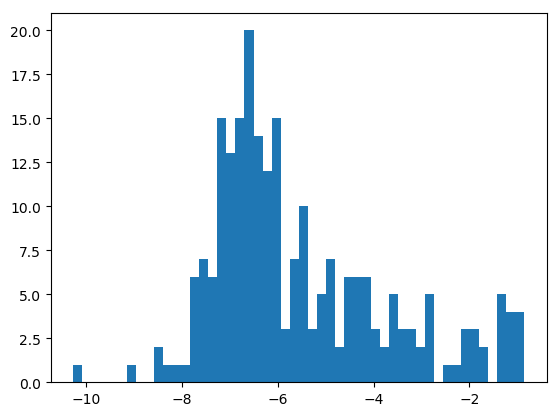

In [15]:
# histogram of sample means
hist(log.(sample_mean),50);

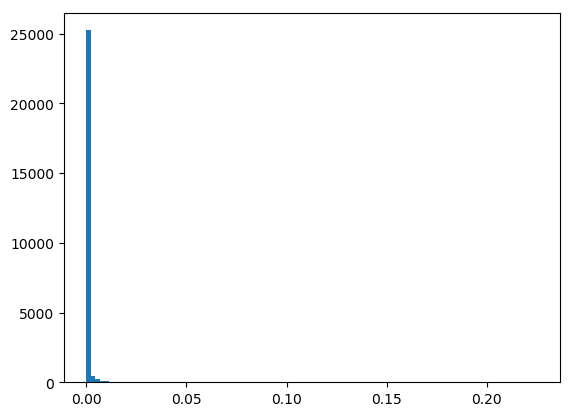

In [16]:
# histogram of sample 2nd moments
inputvec_2ndmom=inputvec[L+1:end]
hist(inputvec_2ndmom,100);

### compare inferred landscapes

In [17]:
# landscapes inferred by John's ACE and MC programs
ACE_params1=readdlm("p24 landscape/p24-g2-0.0005-b-5870-gh-0.001/p24-out-learn.j")
ACE_params2=readdlm("p24 landscape/p24-g2-0.0005-b-5870-gh-0.0002/p24-out-learn.j");

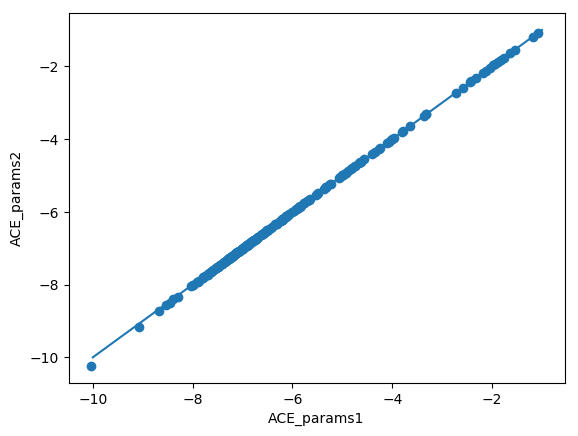

In [18]:
# fields
scatter(ACE_params1[1:L],ACE_params2[1:L])
xlabel("ACE_params1")
ylabel("ACE_params2")

plot(collect(-10:1:-1),collect(-10:1:-1));

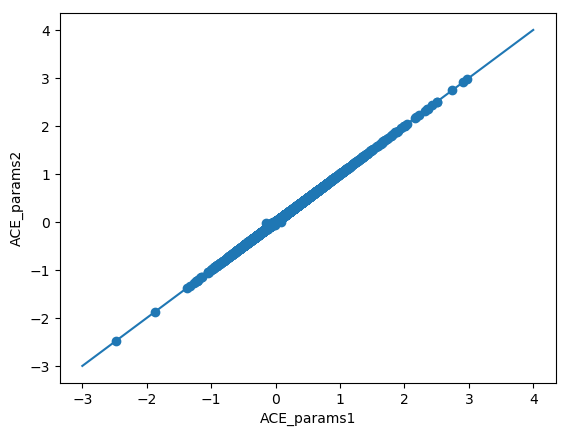

In [19]:
# couplings
scatter(ACE_params1[L+1:end],ACE_params2[L+1:end])
xlabel("ACE_params1")
ylabel("ACE_params2")

plot(collect(-3:1:4),collect(-3:1:4));